John Crowe - Quantitative Asset Management HW #3 - Momentum

# Using CRSP stock data, define the universe of monthly returns that can be used in calculating momentum portfolios, as well as their ranking return, following the procedure in Daniel and Moskowitz (2016). Your output should be from 1927-2023.

Same as problem sets 1 and 2, we are going to import the CRSP data for Stocks.  The risk free rate is from the French Fama numbers (not CRSP) which we download below, per the directions. We will combine the dlret and ret data for the stocks and create 'cum_div_ret' to encompass all returns for stocks. We will filter our stocks to only use the 10 and 11 sharecodes and the 1, 2 and 3 exchanges, per the French Fama website. We will use the French Fama method for replicating the excess stock returns. I made the same assumptions for the Daniel and Moskowitz portfolio. 

Below is a list of the libraries I used for this project.

In [1]:
import wrds
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import pandas_datareader
import datetime
import numpy as np
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt

Below I connected the script to the “WRDS” servers so I could access the data for the stocks.

In [2]:
id = 'johncrowe'
conn = wrds.Connection(id)

Enter your WRDS username [jcrowe95]:johncrowe
Enter your password:········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: y
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


Below is code copied from the professor and shown in class. This allows us to connect to the CRSP servers and extract data that we otherwise would not have access to.

In [3]:
crsp_raw = conn.raw_sql("""
                      select a.permno, a.permco, a.date, b.shrcd, b.exchcd,
                      a.ret, a.retx, a.shrout, a.prc, a.cfacshr, a.cfacpr
                      from crspq.msf as a 
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/1900' and '12/31/2023'
                      """)

Below is some data cleaning and rearraning. First we arrange by date and permno, then we manipulate the date portion so that we can ensure they are in the proper order. A lot of this code was provided by the professor.

In [4]:
crsp_raw = crsp_raw.sort_values(['permno','date']).reset_index(drop=True).copy()
crsp_raw[['permno', 'permco']] = crsp_raw[['permno', 'permco']].astype(int)
crsp_raw['date'] = pd.to_datetime(crsp_raw['date'], format='%y-%m-%d') + MonthEnd(0)
crsp_raw['prc'] = np.absolute(crsp_raw['prc'])

In [5]:
dlret_raw = conn.raw_sql("""
                       select permno, dlret, dlstdt, dlstcd
                       from crspq.msedelist
                       """)

Below we are retrieving the delisted data for the stocks so that we can create our 'cum_div_ret' tab which we use for calculating our stock returns.

In [6]:
dlret_raw = dlret_raw.sort_values(['permno', 'dlstdt']).reset_index(drop=True).copy()
dlret_raw.permno = dlret_raw.permno.astype(int)
dlret_raw['dlstdt'] = pd.to_datetime(dlret_raw['dlstdt'])
dlret_raw['date'] = dlret_raw['dlstdt'] + MonthEnd(0)

Here we have all of the relevant stock columns we need for creating our final dataframe.

In [7]:
crsp_data = crsp_raw[['date', 'permno', 'shrcd', 'exchcd', 'ret', 'prc', 'shrout']].copy()
crsp_data = crsp_data.dropna()

Here we merge our stock data frame with the delisted stock returns and fill the 'Na' values with 0, per instruction from the Fama French website and assuming the same method for Daniel and Moskowitz. We use an outer merge so that we do not drop any information about the stocks and keep all we have available. The below warnings do not seem to impact the dataframes we created.

In [8]:
crsp_Stocks = crsp_data.merge(dlret_raw[['permno','date','dlret']], how='outer', on=['permno','date'])
crsp_Stocks['dlret'] = crsp_Stocks['dlret'].fillna(0)
crsp_Stocks['shrcd'] = crsp_Stocks['shrcd'].fillna(method='ffill')
crsp_Stocks['exchcd'] = crsp_Stocks['exchcd'].fillna(method='ffill')
crsp_Stocks['ret'] = crsp_Stocks['ret'].fillna(0)
crsp_Stocks['prc'] = crsp_Stocks['prc'].fillna(0)
crsp_Stocks['shrout'] = crsp_Stocks['shrout'].fillna(0)

/tmp/ipykernel_6723/917011597.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  crsp_Stocks['shrcd'] = crsp_Stocks['shrcd'].fillna(method='ffill')
/tmp/ipykernel_6723/917011597.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  crsp_Stocks['exchcd'] = crsp_Stocks['exchcd'].fillna(method='ffill')


Same as problem sets 1 and 2, we will filter our stocks to only use index 10 and 11 for 'shrcd', and exchanges 1, 2, and 3 per the Fama French website requirements. We had some warnings come up upon running this code, but they do not seem to affect the output.

In [9]:
stocks = crsp_Stocks[((crsp_Stocks['shrcd'] == 10) | (crsp_Stocks['shrcd'] == 11)) & ((crsp_Stocks['exchcd'] == 1) | (crsp_Stocks['exchcd'] == 2) | (crsp_Stocks['exchcd'] == 3))]
stocks.loc[:, 'cum_div_ret'] = (1 + stocks['ret']) * (1 + stocks['dlret']) - 1

/tmp/ipykernel_6723/1122760976.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stocks.loc[:, 'cum_div_ret'] = (1 + stocks['ret']) * (1 + stocks['dlret']) - 1


Using our Stock data, we can calculate the stock value by multiplying 'prc' by 'shrout', or number of shares by price per share. This will give us the market cap in thousands, which will be fine for this project. We ensure we calculate the lagged market cap by merging the stock dataframe for the current month with the stock data from from the previous month. We keep the return of the current month and use the 'prc' and 'shrout' from the previous month so that we have the lagged market cap with the return. This simulates an investment in the stock for the period we get the momentum indicator. The 'Ret' column was interpretted to be this month's returns, since that would be the returns seen by the stock if we decided to invest based on the momentum indicators.

For this problem, we are just calculating returns, so we are not factoring in the risk free rate to determine excess returns. Same as in problem set 1 and 2, we iterate through every month but this time skip the first 12 months of data. We do this since we need the last 12 months of data to rank the stocks according to return. 

Per methods utilized by both French and Daniel and Moskowitz, we observe every single stock for every month. We only consider the stocks that existed continuously for the last 13 months (current month plus last 12 months). We do this so we do not have stocks with missing data for this time period that could cause errors in the code. We also do this because this strategy is easily replicable in real life. While Daniel and Moskowitz also considered utilizing stocks that were present in month $t-12$ plus another 7 different months plus month $t-1$, I found this hard to implement and too prone to error. Therefore we only considered stocks that existed for all 13 months, since it seems to be a much safer and realistic method.

In the below function, we go through every month and filter for stocks that existed continuously for the last 13 months. We then summed all of the stock returns for months $t-12$ to $t-2$, giving us 11 months of return data. We did not include data for month $t-1$, per direction from Daniel and Moskowitz. We then ranked all stocks, with 1 being the lowest return and a higher ranking corresponding to a higher return. Every month, each stock will get a new ranking, so our output will be for every stock-month-year. We could then return our findings and use this new data frame in the next problems.

The final output is from 1927-2023, with a row for every year-month-stock.

In [10]:

def PS3_Q1(df):
    
    # First let's create a list containing our dates, so we can find the last 13 months of data for momentum
    dates = []
    final_df = pd.DataFrame()
    for index, date in enumerate(sorted(df['date'].unique())):
        dates.append(date)
        
        # We can skip the first 12 dates, since we need atleast 13 months for a momentum portfolio
        if (index > 11):
            # Get dates we want to use for our stocks
            momentum_dates = dates[-13:]

            # Filter for the stocks present in the current month and the last 12 months
            momentum_stocks = df[df['date'].isin(momentum_dates)]
            
            # Next filter for the stocks present in all of the previous 13 months
            counts = momentum_stocks['permno'].value_counts()
            valid_permnos = counts[counts == 13].index
            filtered_df = momentum_stocks[momentum_stocks['permno'].isin(valid_permnos)]
              
            # Stock information for this step
            this_step_stocks = filtered_df[filtered_df['date'] == date].copy()
            
            # Create lagged market value df from last step
            lagged_cap = filtered_df[filtered_df['date'] == momentum_dates[-2]].copy()
            lagged_cap['lag_Mkt_Cap'] = lagged_cap['prc']*lagged_cap['shrout']
            
            # Drop the current month and t-1 month since we are not using these for computing our momentum return
            filtered_df = filtered_df[~filtered_df['date'].isin([date, momentum_dates[-2]])]
            
            # Sum cum_div_ret for months t-12 to t-2
            ret_by_permno = filtered_df.groupby('permno')['cum_div_ret'].sum()
            filtered_df['11_Month_Ret'] = filtered_df['permno'].map(ret_by_permno)
            
            # Get stocks two month ago only, since this has all the information we need with the '11_Month_Ret'
            filtered_df = filtered_df[filtered_df['date'] == momentum_dates[0]]
            
            # Merge momentum months stocks with this months stocks
            stocks_shared = pd.merge(this_step_stocks[['permno', 'exchcd', 'date', 'cum_div_ret']], filtered_df[['permno','11_Month_Ret']], how = 'left', on ='permno')
            
            # Merge last months stocks with this months to get lagged market cap
            final_stocks = pd.merge(stocks_shared[['permno', 'exchcd', 'date', 'cum_div_ret', '11_Month_Ret']], lagged_cap[['permno','lag_Mkt_Cap']], how = 'left', on ='permno')
            
            # Create year, month and ranking ret columns
            final_stocks['Year'] = date.year
            final_stocks['Month'] = date.month
            final_stocks['Ranking_Ret'] = final_stocks['11_Month_Ret'].rank(ascending=True)
            final_stocks.rename(columns={'cum_div_ret': 'Ret'}, inplace=True)

            # Drop columns we do not need
            final_stocks = final_stocks.drop(['date', '11_Month_Ret'], axis=1)
            
            # Reorder columns into desired format
            final_stocks = final_stocks[['Year', 'Month', 'permno', 'exchcd', 'lag_Mkt_Cap', 'Ret', 'Ranking_Ret']]
            
            # Add this month data frame to final dataframe
            final_df = pd.concat([final_df, final_stocks])
        
    return(final_df)



In [11]:
a1 = PS3_Q1(stocks)
a1

,Year,Month,permno,exchcd,lag_Mkt_Cap,Ret,Ranking_Ret
0,1927,1,10022,1.0,1.142400e+04,-0.075893,329.0
1,1927,1,10030,1.0,2.145000e+04,0.009545,278.0
2,1927,1,10057,1.0,3.062500e+03,-0.051020,12.0
3,1927,1,10073,1.0,1.276500e+03,0.094595,69.0
4,1927,1,10081,1.0,5.960000e+03,-0.075000,41.0
...,...,...,...,...,...,...,...
3925,2023,12,85953,3.0,4.552125e+03,-0.546667,549.0
3926,2023,12,87269,3.0,5.885568e+04,-0.221374,1522.0
3927,2023,12,87302,3.0,3.775490e+04,0.000000,3695.0
3928,2023,12,87361,3.0,1.335426e+05,0.014493,3670.0


# Define the monthly momentum portfolio decile of each stock as defined by both Daniel and Moskowitz (2016) and Kenneth R. French. Your output should be from 1927-2023.

For Daniel and Moskowitz, we have the following information for momentum decile classification: "All firms meeting the data requirements are then placed into one of ten decile portfolios based on this ranking, where portfolio 10 represents the winners (those with the highest past returns) and portfolio 1 the losers." This just means the stocks are evenly divided into different deciles. For example, if we had 20 stocks and one stock with the 9th best returns and one stock with the 10th best returns, we would be them into deciles 1 and 6, respectively. 

The portfolios used in Ken French's (KRF) data library were formed in a manner largely consistent with the decile momentum portfolios in Daniel and Moskowitz. The biggest difference was that the portfolio breakpoints for the KRF portfolios were set so that each of the portfolios has an equal number of NYSE firms (sharecode = 1). This means we filtered for stocks in the NYSE firms and evenly sorted them out into deciles 1 through 10. I then used this sorting to define the new boundaries and set the remaining firms according to this boundary. Every month-year-stock has two different decile rankings for both the DM portfolio and the KRF portfolio. These deciles are usually the same for each stock, but could differ by one (or more) deciles for a given month-year-stock. For example, stocks in 1927 were almost entirely NYSE stocks, so the two ranking systems were mostly the same. As time progressed, however, the other exchanges became more prominent and the two decile ranking systems could differ significantly from one another.

One reason we want to divide all stocks based on the NYSE stocks is because the NYSE is a simple measure to include largely traded stocks. If our bottom portfolio contained no NYSE stocks, it could skew our portfolio and increase risk with many low cap, less traded stocks. This method is a good way to ensure the portfolio is more easily constructable.


In [12]:
def PS3_Q2(df):
    
    # Create final_df to store all of our values from each month and year
    final_df = pd.DataFrame()
    
    # Run a nested for loop through each unique year and month
    for index_y, year in enumerate(sorted(df['Year'].unique())):
        for index_m, month in enumerate(sorted(df['Month'].unique())):
            
            # Create dataframe of all stocks for this specific month and date
            all_stocks = df[(df['Year'] == year) & (df['Month'] == month)].copy()
            
            # Create dataframe of all NYSE stocks for this specific month and date
            nyse = df[(df['Year'] == year) & (df['Month'] == month) & (df['exchcd'] == 1)].copy()
            
            # Get ranges for the Ranking_Ret quartiles
            nyse['Quartile'] = pd.qcut(nyse['Ranking_Ret'], q=10, labels=False)
            quartile_ranges = nyse.groupby('Quartile')['Ranking_Ret'].agg(['min', 'max'])
            
            # Increase max index so we do not leave any stocks behind
            quartile_ranges.iloc[9, 1] *= 2
            quartile_ranges += 1
            stock_bins = [0] + quartile_ranges['max'].tolist()

            # Map ranges to all stocks giving us the KRF_decile
            all_stocks['KRF_decile'] = pd.cut(all_stocks['Ranking_Ret'], bins=stock_bins, labels=range(0, 10), include_lowest=True)
            all_stocks['DM_decile'] = pd.cut(all_stocks['Ranking_Ret'], bins=10, labels=False)
            
            # Add one to the deciles to match the D&M Paper format
            all_stocks['KRF_decile'] = all_stocks['KRF_decile'].astype(int) + 1
            all_stocks['DM_decile'] = all_stocks['DM_decile'].astype(int) + 1
            
            # Reorder columns into desired format
            all_stocks = all_stocks[['Year', 'Month', 'permno', 'lag_Mkt_Cap', 'Ret', 'DM_decile', 'KRF_decile', 'exchcd']]
            final_df = pd.concat([final_df, all_stocks])
        
    return(final_df)


In [13]:
a2 = PS3_Q2(a1)
a2

,Year,Month,permno,lag_Mkt_Cap,Ret,DM_decile,KRF_decile,exchcd
0,1927,1,10022,1.142400e+04,-0.075893,8,8,1.0
1,1927,1,10030,2.145000e+04,0.009545,7,7,1.0
2,1927,1,10057,3.062500e+03,-0.051020,1,1,1.0
3,1927,1,10073,1.276500e+03,0.094595,2,2,1.0
4,1927,1,10081,5.960000e+03,-0.075000,1,1,1.0
...,...,...,...,...,...,...,...,...
3925,2023,12,85953,4.552125e+03,-0.546667,2,1,3.0
3926,2023,12,87269,5.885568e+04,-0.221374,4,3,3.0
3927,2023,12,87302,3.775490e+04,0.000000,10,10,3.0
3928,2023,12,87361,1.335426e+05,0.014493,10,10,3.0


# Calculate the monthly momentum portfolio decile returns as defined by both Daniel and Moskowitz (2016) and Kenneth R. French. Your output should be from 1927-2023.

Below we extract the French Fama data for our stocks. I modified this dataframe to get it into the format specified by this problem, hence most of the below code. This code also uses a built in Python function which we saw in problem set 1 for reach the Fama French data. We only end up using the risk free rate for this problem, since I use the 'HML' data from another another text file per the problem set instructions. We also splice this dataframe to only use the dates required for this problem, 1927 - 2023. We can ignore the warnings below as they do not impact the dataframe.

In [14]:
FF3 = pandas_datareader.famafrench.FamaFrenchReader('F-F_Research_Data_Factors', start='1900', end=str(datetime.datetime.now().year+1))
FF3 = FF3.read()[0]/100

FF3.columns = 'MktRF', 'SMB', 'HML', 'RF'
FF3 = FF3.reset_index().rename(columns={'Date':'date'}).copy()
FF3['date'] = pd.DataFrame(FF3[['date']].values.astype('datetime64[ns]')) + MonthEnd(0)

# Now let's splice this dataframe for the specific dates we need (1927-2023)
FF_Q3 = FF3[6:1170]

# Create Year and Month columns
FF_Q3.loc[:, 'Year'] = FF_Q3['date'].dt.year
FF_Q3.loc[:, 'Month'] = FF_Q3['date'].dt.month

# Drop the date column
FF_Q3 = FF_Q3.drop(['date'], axis=1)

# Rename columns
FF_Q3.rename(columns={'MktRF': 'Market_minus_Rf', 'RF': 'Rf'}, inplace=True)

# Reorder columns to match Q3 format
FF_Q3 = FF_Q3[['Year', 'Month', 'Market_minus_Rf', 'SMB', 'HML', 'Rf']]

/tmp/ipykernel_6723/4039640047.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  FF3 = FF3.read()[0]/100
/tmp/ipykernel_6723/4039640047.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  FF3 = FF3.read()[0]/100
/tmp/ipykernel_6723/4039640047.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FF_Q3.loc[:, 'Year'] = FF_Q3['date'].dt.year
/tmp/ipykernel_6723/4039640047.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of

In [15]:
FF_Q3

,Year,Month,Market_minus_Rf,SMB,HML,Rf
6,1927,1,-0.0006,-0.0037,0.0454,0.0025
7,1927,2,0.0418,0.0004,0.0294,0.0026
8,1927,3,0.0013,-0.0165,-0.0261,0.0030
9,1927,4,0.0046,0.0030,0.0081,0.0025
10,1927,5,0.0544,0.0153,0.0473,0.0030
...,...,...,...,...,...,...
1165,2023,8,-0.0239,-0.0316,-0.0106,0.0045
1166,2023,9,-0.0524,-0.0251,0.0152,0.0043
1167,2023,10,-0.0319,-0.0388,0.0018,0.0047
1168,2023,11,0.0884,-0.0002,0.0164,0.0044


The below code uses the lagged market cap and returns to find the value-weighted return on each portfolio decile for each year-month. Therefore we end up with 10 difference returns for each month of our data. We start by filtering for stocks in a specific month, year and decile. Then we find the total lagged market cap and then the realized return. We can divide the total return by total market cap to find out return for that month. From the output dataframe, we see a high correlation between decile and return, with the higher decile typically corresponding to a higher return. We will analyze the exact historical returns from each of these portfolios in the next problem sets.

Below, df1 is our datframe from problem 2 and df2 is our French Fama dataframe which we need for our risk free rate.

In [17]:
# df1 is our question 2 output and df2 is our French Fama numbers
def PS3_Q3(df1, df2):
    
    # Create lists for our final dataframe
    Years = []
    Months = []
    Deciles = []
    DM_Rets = []
    KRF_Rets = []
    RFs = []
    
    # Iterate through all years and months
    for index_y, year in enumerate(sorted(df1['Year'].unique())):
        for index_m, month in enumerate(sorted(df1['Month'].unique())):
            this_month = df1[(df1['Year'] == year) & (df1['Month'] == month)].copy()
            deciles = [1,2,3,4,5,6,7,8,9,10]
            
            for i in deciles:
                
                # Calculate DM returns for specific Year-Month-Decile
                DM_last_month_value = (this_month[this_month['DM_decile']==i]['lag_Mkt_Cap']).sum()
                DM_this_month_return = (this_month[this_month['DM_decile']==i]['lag_Mkt_Cap']*this_month[this_month['DM_decile']==i]['Ret']).sum()
                DM_Ret = DM_this_month_return/DM_last_month_value
                
                # Calculate KRF returns for specific Year-Month_Decile
                KRF_last_month_value = (this_month[this_month['KRF_decile']==i]['lag_Mkt_Cap']).sum()
                KRF_this_month_return = (this_month[this_month['KRF_decile']==i]['lag_Mkt_Cap']*this_month[this_month['KRF_decile']==i]['Ret']).sum()
                KRF_Ret = KRF_this_month_return/KRF_last_month_value
                
                # Calculate risk free rates
                RF = df2[(df2['Year'] == year) & (df2['Month'] ==  month)]['Rf'].iloc[0]

                # Append all of our data for our new dataframe
                Years.append(year)
                Months.append(month)
                Deciles.append(i)
                DM_Rets.append(DM_Ret)
                KRF_Rets.append(KRF_Ret)
                RFs.append(RF)
                
    data = {
    'Year': Years,
    'Month': Months,
    'decile': Deciles,
    'DM_Ret': DM_Rets,
    'KRF_Ret': KRF_Rets,
    'Rf': RFs
}

    final_df = pd.DataFrame(data)

    return(final_df)
        

In [18]:
a3 = PS3_Q3(a2, FF_Q3)
a3

,Year,Month,decile,DM_Ret,KRF_Ret,Rf
0,1927,1,1,-0.031408,-0.031408,0.0025
1,1927,1,2,-0.002443,-0.002443,0.0025
2,1927,1,3,0.000676,0.000676,0.0025
3,1927,1,4,0.006179,0.006098,0.0025
4,1927,1,5,0.000776,0.000945,0.0025
...,...,...,...,...,...,...
11635,2023,12,6,0.043101,0.038485,0.0043
11636,2023,12,7,0.052971,0.040845,0.0043
11637,2023,12,8,0.035669,0.037391,0.0043
11638,2023,12,9,0.037319,0.036396,0.0043


# Recreate Table 1 from Daniel and Moskowitz (2016), but exclude the rows for α, t(α), β, and sk(d), as well as the Market column. Ensure your version closely follows the original table’s format and methods. Use the entire data sample for your statistics. Additionally, calculate and include a new row at the bottom of your table showing the correlation between your portfolio returns and the decile-based breakpoints from Daniel and Moskowitz (2016), as well as the returns listed on Daniel’s website. Refer to the extra materials provided at the end of this assignment for an example on the table format and expected outcome.

For this problem, we are recreating the data table shown on the Daniel Moskowitz paper. We can utilize our dataframe output from problem 3 as our input, since this has all of the data for each year-month-decile plus the risk free rate. We can then filter our dataframe for each specific decile and find the average monthly return. We convert from monthly return to annualized return using the formula below:

$$
r_{annual} = 12*r_{monthly}
$$

And from monthly standard deviation to annualized standard deviation using the formula below:

$$
\sigma_{annual} = \sqrt{12}*\sigma_{monthly}
$$

The sk(m) column is the full-period realized skewness of the monthly log returns (not excess) to the portfolios. We used the below formula for this:

$$
R_t = ln\big(\frac{P_t}{P_{t-1}}\big)
$$

The WML portfolio can be viewed as the zero initial value long-short portfolio that shorts decile 1 and invests that money into decile 10. 

Before we implement this in PS3_Q4, we first need to splice our data frames to achieve the dates in the Daniel and Moskowitz paper. This means we need all year-month-decile data from January 1927 to March 2013. The below code splices our function 3 output to only include these specific dates.

In [19]:
Q4_a = a3[:10350]
Q4_a

,Year,Month,decile,DM_Ret,KRF_Ret,Rf
0,1927,1,1,-0.031408,-0.031408,0.0025
1,1927,1,2,-0.002443,-0.002443,0.0025
2,1927,1,3,0.000676,0.000676,0.0025
3,1927,1,4,0.006179,0.006098,0.0025
4,1927,1,5,0.000776,0.000945,0.0025
...,...,...,...,...,...,...
10345,2013,3,6,0.041850,0.041818,0.0000
10346,2013,3,7,0.035709,0.035631,0.0000
10347,2013,3,8,0.045813,0.042467,0.0000
10348,2013,3,9,0.044108,0.048346,0.0000


Per the problem set, we also have a provided txt file containing the year-month-deciles for the DM portfolio. The below code imports the data, converts the date to month and year, rearranges the data per the problem input, and then  splices for the desired dates of the Daniel and Moskowitz paper. We need this data to find the correlation between the DM dataset and the replicated data.

In [20]:
# Pull data from our txt file
df_DM_data = pd.read_csv('m_m_pt_tot.txt', header=None, delim_whitespace=True, names=['date', 'decile', 'DM_Ret_actual', 'd', 'e'])

# Convert 'date' column to month and year
df_DM_data['Year'] = df_DM_data['date'].apply(lambda x: int(str(x)[:4]))
df_DM_data['Month'] = df_DM_data['date'].apply(lambda x: int(str(x)[4:6]))

# Drop unused columns
df_DM_data = df_DM_data.drop(['d', 'e', 'date'], axis=1)

# Rearrange columns
df_DM_data = df_DM_data[['Year', 'Month', 'decile', 'DM_Ret_actual']]

# Splice to achieve desired dates
Q4_b = df_DM_data[:10350]
Q4_b

,Year,Month,decile,DM_Ret_actual
0,1927,1,1,-0.03362
1,1927,1,2,-0.04584
2,1927,1,3,0.02755
3,1927,1,4,-0.00319
4,1927,1,5,-0.00294
...,...,...,...,...
10345,2013,3,6,0.04333
10346,2013,3,7,0.03431
10347,2013,3,8,0.04808
10348,2013,3,9,0.05375


Below, df1 is the problem 3 output and df2 is the actual DM data used for finding the correlation.

In [21]:
def PS3_Q4(df1, df2):
    
    # Merge df1 and df2 for simplicity for each year-month-decile
    df = pd.merge(df1[['Year', 'Month', 'decile', 'DM_Ret', 'KRF_Ret', 'Rf']], df2[['Year','Month', 'decile', 'DM_Ret_actual']], how = 'left', on =['Year', 'Month', 'decile'])
    decile_returns = []
    sds = []
    SRs = []
    sk_ms = []
    correlations = []
    
    # Iterate through the 10 different deciles
    for i in range(1,11):
        
        # Calculate average annual excess return
        this_decile_return = 1200*(df[df['decile'] == i]['DM_Ret'] - df[df['decile'] == i]['Rf']).mean()
        
        # Calculate average annual standard deviation
        sd = 100*np.sqrt(12)*(df[df['decile'] == i]['DM_Ret'] - df[df['decile'] == i]['Rf']).std()
        
        # Calculate average annual Sharpe Ratio
        SR = this_decile_return/sd
        
        # Calculate average sk(m)
        sk_m = (np.log(df[df['decile'] == i]['DM_Ret'] + 1)).skew()
        
        # Calculate correlation between replicated and actual datasets
        correlation = df[df['decile'] == i]['DM_Ret'].corr(df[df['decile'] == i]['DM_Ret_actual'])
        
        # Append our results to each respective list
        decile_returns.append(this_decile_return)
        sds.append(sd)
        SRs.append(SR)
        sk_ms.append(sk_m)
        correlations.append(correlation)

    # Compute WML metrics, using same methods as above
    W = df[df['decile'] == 10]['DM_Ret'].reset_index(drop=True)
    L = df[df['decile'] == 1]['DM_Ret'].reset_index(drop=True)
    WML_ret = 1200*(W - L).mean()
    WML_std = 100*np.sqrt(12)*(W - L).std()
    WML_SR = WML_ret/WML_std
    WML_skm = (np.log(W - L + 1)).skew()
    WML_corr = (W - L).reset_index(drop=True).corr(df[df['decile'] == 10]['DM_Ret_actual'].reset_index(drop=True) - df[df['decile'] == 1]['DM_Ret_actual'].reset_index(drop=True))

    # Append WML to lists
    decile_returns.append(WML_ret)
    sds.append(WML_std)
    SRs.append(WML_SR)
    sk_ms.append(WML_skm)
    correlations.append(WML_corr)
    
    # Construct our new data frame as our output
    data = {
    'Deciles': ['Decile 1', 'Decile 2', 'Decile 3', 'Decile 4', 'Decile 5', 'Decile 6', 'Decile 7', 'Decile 8', 'Decile 9', 'Decile 10', 'WML'],
    '$r - r_f$': decile_returns,
    'σ': sds,
    'SR': SRs,
    'sk(m)': sk_ms,
    'correlations': correlations
    }


    final_df = pd.DataFrame(data)
    return(final_df.T)

In [22]:
a4 = PS3_Q4(Q4_a, Q4_b)
a4

,0,1,2,3,4,5,6,7,8,9,10
Deciles,Decile 1,Decile 2,Decile 3,Decile 4,Decile 5,Decile 6,Decile 7,Decile 8,Decile 9,Decile 10,WML
$r - r_f$,-1.380638,2.714312,3.975395,6.317814,7.161187,7.707598,9.485276,10.561142,11.909923,15.84955,17.230188
σ,33.562886,27.205496,23.628479,21.631007,20.500398,19.772286,19.734472,20.482786,22.022382,26.825232,28.151001
SR,-0.041136,0.099771,0.168246,0.292072,0.349319,0.389818,0.480645,0.515611,0.54081,0.590845,0.612063
sk(m),-0.175432,-0.096621,-0.071965,-0.082455,-0.36119,-0.545506,-0.461684,-0.48927,-0.592111,-0.877396,-4.947399
correlations,0.974773,0.969515,0.968217,0.955057,0.965179,0.962973,0.964932,0.956346,0.96895,0.971637,0.905514


In the above table, we can see our replicated Daniel and Moskowitz data for January 1926 to March 2013. While that data is not an exact replication and can be off by as much as a percent for some of the deciles, the general trends in the replication portfolio are extremely similar to the paper. We can see that we typically have a strong correlation of around 95\% to 97\%. We also see extremely strong trends and a general increase as we move from decile 1 to decile 10. The WML long-short portfolio return was found to be 17.23\%, showing the "magic" of the momentum portfolio. My portfolio constructed returns based on returns from $t-12$ to $t-2$ months. We could also try to find returns based on momentum rankings for returns from $t-12$ to $t-1$ months. While my numbers are very close to the actual replication, they are not exact for a few likely reasons.

One of the reasons would be that I decided to require stocks to be consistently listed for 13 months straight. Some of the Daniel and Moskowitz stocks could have only existied for 8 months out of the 13 months and still be included in the DM portfolio. I thought my method was easier to implement, more realistic and would not bring up several NaN erros in the code. Plus with my method, we gain a more comprehensive picture of the stock momentum directions.

Another possible reason for not obtaining exact replication is my choosing stocks that only existing on the NYSE, AMEX and NASDAQ. Daniel and Moskowitz could have considered stocks from other exchanges or countries. There is also a possibility of them using other methods unspecified in their paper when constructing these momentum portfolios. Regardless of not obtaining the exact numbers, we still achieved a very high correlation that shows the power of a momentum portfolio.

# Recreate Table 1 from Daniel and Moskowitz (2016), but exclude the rows for α, t(α), β, and sk(d), as well as the Market column. Ensure your version closely follows the original table’s format and methods. Use the entire data sample for your statistics.

This question we will do the same as in problem 4 except we will use the 'KRF_Ret' returns instead. Since this is a different method from what Daniel and Moskowitz used to compute their portfolio, we observe it to have a lower correlation than our DM replication. The below code is exactly the same as PS3_Q4, only we use the different returns we just specified.

In [23]:
def PS3_Q5(df1, df2):
    
    # Merge df1 and df2 for simplicity
    df = pd.merge(df1[['Year', 'Month', 'decile', 'DM_Ret', 'KRF_Ret', 'Rf']], df2[['Year','Month', 'decile', 'DM_Ret_actual']], how = 'left', on =['Year', 'Month', 'decile'])
    decile_returns = []
    sds = []
    SRs = []
    sk_ms = []
    correlations = []
    for i in range(1,11):
        this_decile_return = 1200*(df[df['decile'] == i]['KRF_Ret'] - df[df['decile'] == i]['Rf']).mean()
        sd = 100*np.sqrt(12)*(df[df['decile'] == i]['KRF_Ret'] - df[df['decile'] == i]['Rf']).std()
        SR = this_decile_return/sd
        sk_m = (np.log(df[df['decile'] == i]['KRF_Ret'] + 1)).skew()
        correlation = df[df['decile'] == i]['KRF_Ret'].corr(df[df['decile'] == i]['DM_Ret_actual'])
        # Append our results to each respective list
        decile_returns.append(this_decile_return)
        sds.append(sd)
        SRs.append(SR)
        sk_ms.append(sk_m)
        correlations.append(correlation)

    # Compute WML metrics
    W = df[df['decile'] == 10]['KRF_Ret'].reset_index(drop=True)
    L = df[df['decile'] == 1]['KRF_Ret'].reset_index(drop=True)
    WML_ret = 1200*(W - L).mean()
    WML_std = 100*np.sqrt(12)*(W - L).std()
    WML_SR = WML_ret/WML_std
    WML_skm = (np.log(W - L + 1)).skew()
    WML_corr = (W - L).reset_index(drop=True).corr(df[df['decile'] == 10]['DM_Ret_actual'].reset_index(drop=True) - df[df['decile'] == 1]['DM_Ret_actual'].reset_index(drop=True))

    # Append WML to lists
    decile_returns.append(WML_ret)
    sds.append(WML_std)
    SRs.append(WML_SR)
    sk_ms.append(WML_skm)
    correlations.append(WML_corr)
    
    data = {
    'Deciles': ['Decile 1', 'Decile 2', 'Decile 3', 'Decile 4', 'Decile 5', 'Decile 6', 'Decile 7', 'Decile 8', 'Decile 9', 'Decile 10', 'WML'],
    '$r - r_f$': decile_returns,
    'σ': sds,
    'SR': SRs,
    'sk(m)': sk_ms,
    'correlations': correlations
    }


    final_df = pd.DataFrame(data)
    return(final_df.T)

In [24]:
a5 = PS3_Q5(Q4_a, Q4_b)
a5

,0,1,2,3,4,5,6,7,8,9,10
Deciles,Decile 1,Decile 2,Decile 3,Decile 4,Decile 5,Decile 6,Decile 7,Decile 8,Decile 9,Decile 10,WML
$r - r_f$,0.743533,4.895264,5.402337,6.706657,6.860812,7.811817,8.826898,10.274905,11.244684,15.00374,14.260207
σ,31.289706,25.988591,22.800719,21.031739,20.284461,19.726765,19.367458,19.975941,21.057523,25.073906,25.359772
SR,0.023763,0.188362,0.236937,0.318883,0.33823,0.396001,0.455759,0.514364,0.533998,0.598381,0.562316
sk(m),0.005319,-0.059555,-0.029618,0.003202,-0.362228,-0.600033,-0.437006,-0.536854,-0.563112,-0.988151,-5.716016
correlations,0.959868,0.95338,0.950121,0.93864,0.952934,0.957254,0.957115,0.95811,0.964181,0.965028,0.880829


From the table, we can see we do not achieve as high of a WML return as with the Daniel and Moskowitz portfolio construction. We should note, however, that this WML has a smaller annual standard deviation (around 3\% less). This makes intuitive sense since we could consider the NYSE stocks to be larger cap and slightly more stable. The means the KRF portfolio is less likely to have many lower cap, higher risk, non NYSE stocks to compose our loser portion of the portfolio, making the KRF decile 1 less risky. So while the KRF portfolio does not achieve returns as high as the DM portfolio, it likely performs better than the DM portfolio during market downturns. 

# Has the momentum anomaly worked in the past few years? Show and discuss empirical evidence.

In this problem, I consider the past few years to mean the last 5 years of stock returns. We can therefore consider data from January 2019 to December 2023. We can run this through our PS3_Q4 function to see how the returns have been. 

The below code splices our data so that we have the desired Year-Month-deciles. Unfortunately our DM data from the provided txt file only runs until 2016, so the correlation will show up as 'NaN', but we can assume it will be similar values to our previous dataframe.

In [25]:
Q6_a = a3[11040:]

The below dataframe is for the actual DM_Ret for our correlation. This data is only available up to 2016, so we won't be able to use if for our data, as explained above.

In [26]:
Q6_b = df_DM_data

In [27]:
a6 = PS3_Q4(Q6_a, Q6_b)
a6

,0,1,2,3,4,5,6,7,8,9,10
Deciles,Decile 1,Decile 2,Decile 3,Decile 4,Decile 5,Decile 6,Decile 7,Decile 8,Decile 9,Decile 10,WML
$r - r_f$,6.512733,10.47364,11.045102,21.756983,11.560194,11.75624,13.937003,8.733539,12.092034,26.52173,20.008997
σ,48.299216,35.456598,27.501355,25.005551,19.813507,19.186722,19.18257,17.497196,19.17122,30.120705,36.869308
SR,0.134841,0.295393,0.40162,0.870086,0.58345,0.612728,0.726545,0.499139,0.630739,0.880515,0.542701
sk(m),0.350327,-0.791807,-0.331178,-0.537441,-0.726348,-0.597831,-0.194922,-0.305156,-0.163828,0.234674,-1.623488
correlations,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As you can see from the data, the WML has a return of over 20\%, so we can consider this a successful trading strategy of the last 5 years. The WML portfolio does have a variance of over 10\% higher than the historical, so we would need to take that into account as well. From these trading strategies, we can see the WML portfolio typically does very well if we stick with this stategy for several years. It tends to fail spectacularly during market downturns and can result in huge losses. The graph below helps illustrate this.

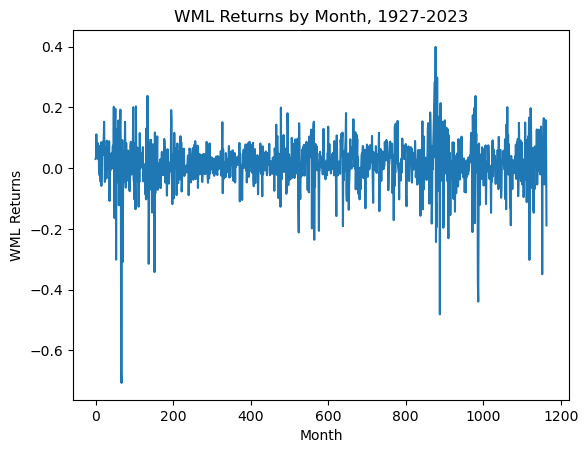

In [28]:
# Create WML portfolio using question 3 output
WML = a3[a3['decile'] == 10]['DM_Ret'].reset_index(drop=True) - a3[a3['decile'] == 1]['DM_Ret'].reset_index(drop=True)

# Graph monthly returns
plt.plot(WML.index, WML)

# Add labels and title
plt.xlabel('Month')
plt.ylabel('WML Returns')
plt.title('WML Returns by Month, 1927-2023')

# Show the plot
plt.show()


As you can see from the above returns, the WML portfolio returns tends to have a high monthly standard deviation. This can make the portfolio risky during market downturns. In the above chart, we even see returns getting as low as -60\% during a particularly bad month and several time exceeding losses of -20\%. These are remarkably terrible returns since the WML is a highly diversified portfolio, investing in every industry and containing around 20\% of total stocks available.Thus we have to be understanding of the risks of a momentum portfolio before we implement this strategy.

# Would you implement this trading strategy if you were running your own fund? What are the main implementation challenges to consider?

While the momentum trading strategies like the DM portfolio we constructed above tend to produce returns well in excess of the average market return, we have to be aware of this strategy's risk before we invest in such a portfolio. One such risk is a high standard deviation, as we saw from problem 4 and 5. The DM annualized standard deviation was around 28\%, which is slightly higher than the average market annualized standard deviation. We also saw from the graph above the higher potential for bad returns when compared to an unleveraged portfolio. This contributes to a much higher value at risk than other portfolios such as the 60-40 stock bond portfolio we constructed earlier. 

Personally, I would implement this WML portfolio as a trading strategy since the exceptional returns seem to outweigh the potentially large downsides. Before adopting this trading method, however, I would spend considerable time studying historical data to determine trends in momentum. One such trend that is likely to appear is the WML portfolio relationship to the VIX index, with a higher VIX score corresponding to higher losses on the WML portfolio, on average. This is due to the momentum portfolio failing during market downturns. 

Considering just data from 1963 to 2023, the worst months during this time period for the momentum portfolios were:

1.	April 2009:	-34.3%	

2.	January 2001:	-25.3%	

3.	November 2002:	-16.3%	

4.	January 2023:	-16.0%

5.	January 1975:	-13.8%

6.	May 2009:       -12.5%	

7.	November 2020:	-12.4%	


Using the historical value at risk method, this corresponds to a 99% VaR of -12.4% for our WML portfolio. We would therefore need to be comfortable with this VaR number before proceeding with the WML method. If we were investing client's money, they would need to be aware of this strategies upsides and risks.

Other strategies to implement would be avoiding using the momentum strategy during market downturns. We can see in the list above that this strategy did poorly during the 2009 crash as well as the internet bubble. If we can find a way to not use this strategy during these periods of high volatility, we have a better chance of achieving good returns for the WML portfolio and avoiding the months with huge losses.

Other things to consider for this portfolio is if the WML will continue to work into the future. It typically does well when growth stocks do well. Lately the growth stocks have been mainly driven by tech. If tech begins to do poorly and value stocks tend to do better, we could see some sort of mean reversion. In the case of a mean reversion, this portfolio will perform poorly. 

To sum up, the WML strategy is a remarkable "magic" strategy that achieves returns higher on average than the market returns. It comes with its own risks and tends to have very bad months that can result in huge losses. We need to be fully aware of the risks and proceed with caution before pursing this trading strategy. If implemented for a long enough time, returns tend to be very good.